In [1]:
import numpy as np
import matplotlib.pyplot as plt

from functools import partial, reduce
from itertools import product
from math import ceil, floor, log10

import operator
import sys

In [2]:
def matrix_to_valuelist(mat):
    return mat.flatten(order="c")


def axes_to_list(x, y):
    return np.vstack(
        [np.vstack([np.array([xi, yi])[None, :] for yi in y]) for xi in x]
    )


def load_data(as_matrix=False):
    x = np.load("../data/x.npy")
    y = np.load("../data/y.npy")
    f = np.load("../data/f.npy")

    pts = axes_to_list(x, y)
    if not as_matrix:
        f = matrix_to_valuelist(f)

    assert f.shape[0] == pts.shape[0] or as_matrix

    return pts, f


def prod(iterable):
    return reduce(operator.mul, iterable, 1)


def compute_w(epsilon):
    return ceil(log10(1 / epsilon)) + 1


def compute_beta(epsilon):
    return 2.3 * compute_w(epsilon)


def kernel(z, beta):
    return np.exp(beta * (np.sqrt(1 - z * z) - 1))


def nonuniform_grid_size(pts):
    return np.array([len(np.unique(pts[:, i])) for i in range(pts.shape[1])])


def fine_grid_size(nonuniform_grid_size, w, upsampling_factor=2):
    # TODO fix
    return np.ceil(
        np.maximum(
            upsampling_factor * nonuniform_grid_size,
            2 * w * np.ones_like(nonuniform_grid_size),
        )
    ).astype(int)


def fine_grid_spacing(n):
    return 2 * np.pi / n


def compute_alpha(w, n):
    return w * np.pi / n


# smallest location of the grid of w^2 points in the
# uniform grid being influenced by the non-uniform
# point x
def solution1(x, h, alpha):
    return np.ceil((x - alpha) / h).astype(int)


# biggest location of the grid of w^2 points in the
# uniform grid being influenced by the non-uniform
# point x
def solution2(x, h, alpha):
    return np.floor((x + alpha) / h).astype(int)

def compute_krn_vals(kernel, h, x, alpha, start, end):
    return kernel(
        (h * np.arange(start, end + 1) - x) / alpha
    )

## Non-Uniform sampled function

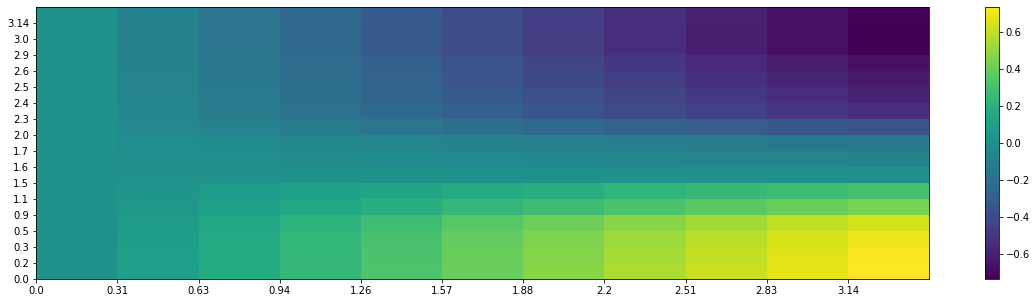

In [3]:
plt.figure(figsize=(20,5))

f = np.load('../data/f.npy')
plt.pcolormesh(f)

x = np.load('../data/x.npy')
y = np.load('../data/y.npy')
plt.xticks(range(f.shape[1]), np.round(x,2))
plt.yticks(range(f.shape[0]), np.round(y,2))

plt.colorbar();

## Loading data

In [4]:
pts, f = load_data()

epsilon = 1.e-12
N = nonuniform_grid_size(pts)

beta = compute_beta(epsilon)
w = compute_w(epsilon)
prt_kernel = partial(kernel, beta=beta)
vec_krn = np.vectorize(prt_kernel)

n = fine_grid_size(N, w)
h = fine_grid_spacing(n)

alpha = compute_alpha(w, n)

print('beta: {}, alpha: {}'.format(beta, alpha))
print('w: {}'.format(w))
print('N: {}, n: {}'.format(N, n))
print('h: {}'.format(h))
print('sol1 for pts[0]: {}'.format(solution1(pts[0], h, alpha)))
print('sol2 for pts[0]: {} '.format(solution2(pts[0], h, alpha)))

beta: 29.9, alpha: [1.57079633 1.20119719]
w: 13
N: [11 17], n: [26 34]
h: [0.24166097 0.18479957]
sol1 for pts[0]: [-6 -6]
sol2 for pts[0]: [6 6] 


## Computation

In [5]:
def worker(nonuniform_idx, pts, f, kernel, n, h, alpha):
    x = pts[nonuniform_idx]
    c = f[nonuniform_idx]

    b = np.zeros(n, dtype=float)
    
    start = solution1(x, h, alpha)
    end = solution2(x, h, alpha)
    start[start < 0] = 0
    end[end > n - 1] = n[end > n - 1] - 1

    # kernel evaluated in the uniform grid (translated with the
    # non-uniform coordinates)
    krn_vals = np.zeros((len(n), np.max(n)), dtype=float)
    for i in range(len(start)):
        if start[i] <= end[i]:
            krn_vals[i, start[i] : (end[i] + 1)] = compute_krn_vals(kernel, h[i], x[i], alpha[i], start[i], end[i])

    for cmb in product(
        *[range(start[i], end[i] + 1) for i in range(len(start))]
    ):
        b[cmb[0], cmb[1]] += c * prod(
            krn_vals[i, cmb[i]] for i in range(len(cmb))
        )

    np.save('../data/b_{}.npy'.format(nonuniform_idx), b)

    return krn_vals, b

In [6]:
krn_valss, bs = zip(*[worker(i, pts, f, vec_krn, n, h, alpha) for i in range(len(pts))])

## Kernel values

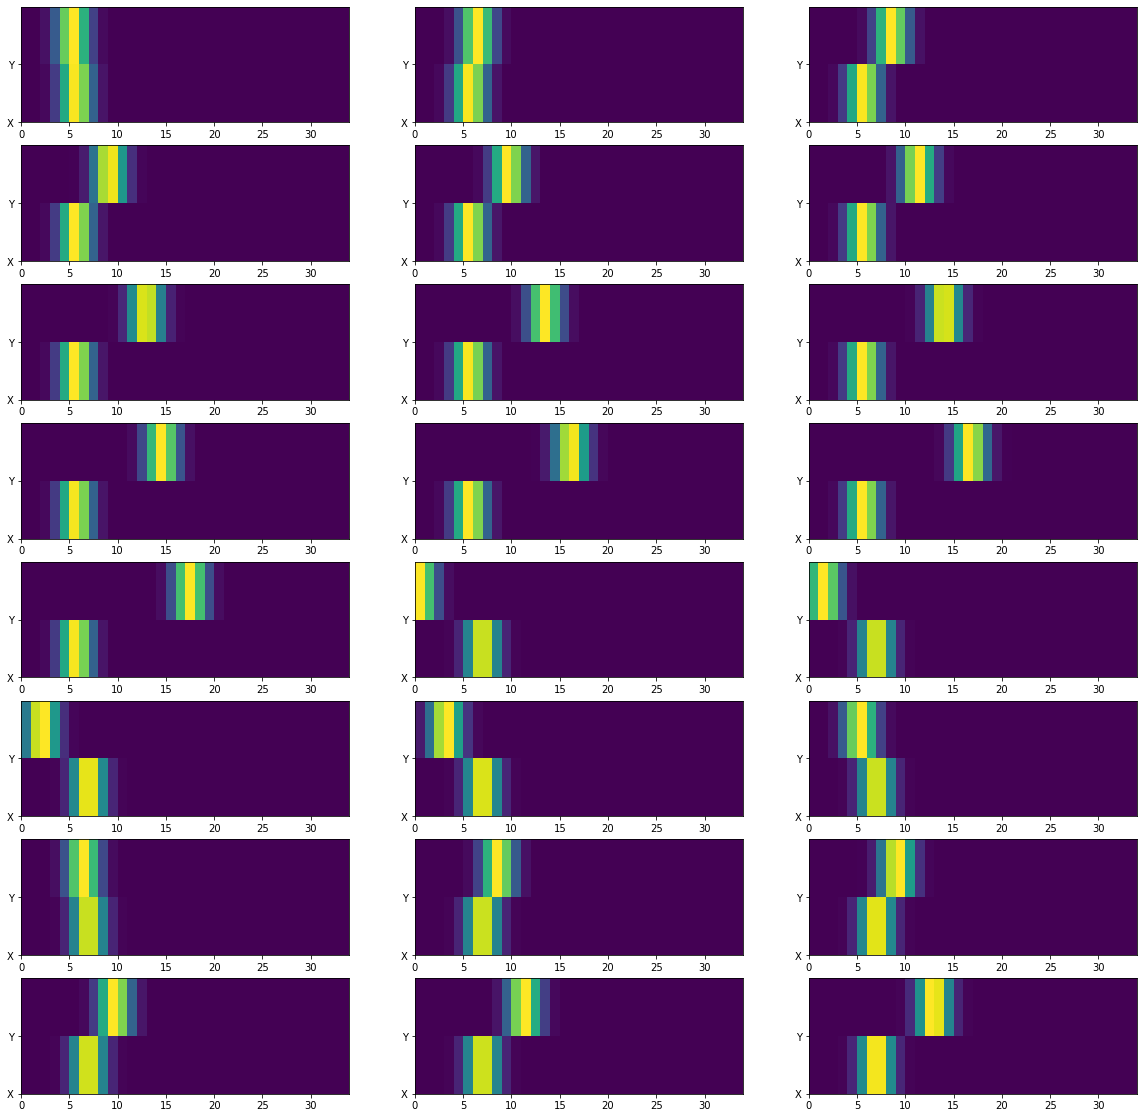

In [7]:
plt.figure(figsize=(20,20))
for pos,i in enumerate(range(72,96)):
    plt.subplot(8,3,pos+1)
    plt.pcolormesh(krn_valss[i])
    plt.yticks(range(2), ['X', 'Y'])

## Uniform grid spreading

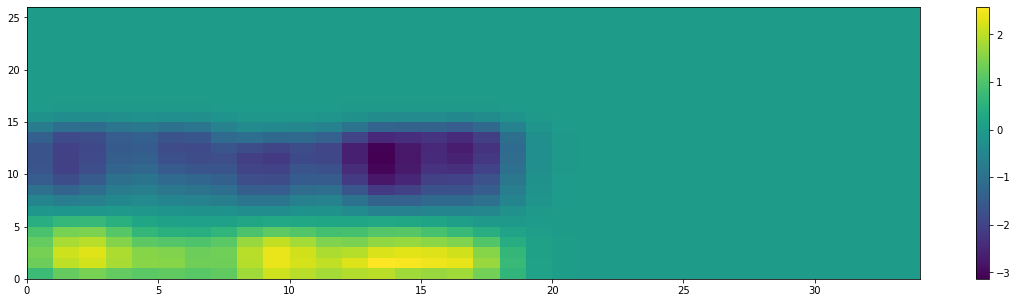

In [8]:
b = np.sum(np.array(bs), axis=0)

plt.figure(figsize=(20,5))
plt.pcolormesh(b)
plt.colorbar();